## Skinthesia Classification Model

## Import Library

In [150]:
import pandas as pd
import ast
import re
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, TextVectorization
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss
from sklearn.metrics import classification_report, accuracy_score, f1_score, hamming_loss, jaccard_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input

## Load Data

In [116]:
# Load the CSV file
df = pd.read_csv('../data/products_integrated_features.csv', encoding='ISO-8859-1')
df.head()

,url,product_name,brand,category,price,rating,skin_type,total_reviews,skin_concern,ingredients,skin_goal,age,rating_star
0,https://reviews.femaledaily.com/products/treat...,2.5,Benzolac,Acne treatment,15000,3.4,"['combination', 'oily']",67367,"['acne', 'irritation']","['salicylic acid', 'bha, retinol', 'centella a...",['calming'],19 - 24,4.267327
1,https://reviews.femaledaily.com/products/treat...,5,Benzolac,Acne treatment,22000,3.7,"['combination', 'oily']",10500,"['acne', 'dryness']","['vitamin c', 'bha', 'aha, bha, salicylic acid...",['non-comedogenic'],19 - 24,4.416667
2,https://reviews.femaledaily.com/products/treat...,10% Lactic + Glycolic Peeling Serum,Somethinc,Peeling,150000,4.0,"['dry', 'normal']",520,"['acne', 'blackheads']","['aha, allantoin, glycerin, panthenol, salicyl...","['brightening', 'hydrating']",25 - 29,4.750000
3,https://reviews.femaledaily.com/products/treat...,2 Minute Peeling Gel,Osho,Peeling,150000,3.9,"['combination', 'dry']",357,"['sensitive', 'irritation']",['aloe vera'],"['hydrating', 'smoothing']",19 - 24,4.647059
4,https://reviews.femaledaily.com/products/treat...,2% Salicylic Acid BHA Acne Spot Treatment,Skintific,Acne treatment,139000,3.9,"['combination', 'oily']",30856,"['acne', 'redness']","['centella asiatica, ceramide, niacinamide, sa...","['calming', 'fast-absorbing']",25 - 29,4.563910


## Data Selection

In [117]:
# Mengambil kolom yang relevan
df = df[['skin_type','skin_concern','skin_goal','ingredients']]
df.head()

,skin_type,skin_concern,skin_goal,ingredients
0,"['combination', 'oily']","['acne', 'irritation']",['calming'],"['salicylic acid', 'bha, retinol', 'centella a..."
1,"['combination', 'oily']","['acne', 'dryness']",['non-comedogenic'],"['vitamin c', 'bha', 'aha, bha, salicylic acid..."
2,"['dry', 'normal']","['acne', 'blackheads']","['brightening', 'hydrating']","['aha, allantoin, glycerin, panthenol, salicyl..."
3,"['combination', 'dry']","['sensitive', 'irritation']","['hydrating', 'smoothing']",['aloe vera']
4,"['combination', 'oily']","['acne', 'redness']","['calming', 'fast-absorbing']","['centella asiatica, ceramide, niacinamide, sa..."


In [118]:
# Information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   skin_type     912 non-null    object
 1   skin_concern  912 non-null    object
 2   skin_goal     912 non-null    object
 3   ingredients   912 non-null    object
dtypes: object(4)
memory usage: 28.6+ KB


## Data Cleaning & Parsing

In [119]:
# Menggunakan ast untuk evaluasi literal
def flatten_list(nested_lst):
    flat = []
    for item in nested_lst:
        if isinstance(item, list):
            flat.extend(flatten_list(item))
        else:
            flat.append(item)
    return flat

# Fungsi untuk parsing dan membersihkan data
def parse_and_clean(cell):
    # Kalau tipe string, coba literal_eval ke list Python
    if isinstance(cell, str):
        try:
            lst = ast.literal_eval(cell)
        except:
            # Kalau gagal eval, anggap saja string biasa dan bungkus jadi list
            lst = [cell]
    else:
        lst = cell

    # Flatten nested list
    flat_list = flatten_list(lst)

    # Split elemen yang masih berupa gabungan string dengan koma
    split_list = []
    for item in flat_list:
        if isinstance(item, str):
            parts = [part.strip() for part in item.split(',')]
            split_list.extend(parts)
        else:
            split_list.append(str(item).strip())

    # Normalisasi, hapus karakter aneh, dan hapus duplikat
    seen = set()
    result = []
    for item in split_list:
        # Hapus tanda kurung siku [ ]
        item_norm = re.sub(r'[\[\]]', '', item.lower().strip())
        if item_norm and item_norm not in seen:
            seen.add(item_norm)
            result.append(item_norm)

    return result

In [120]:
# Apply the parsing and cleaning function to each column
cols = df.columns
for col in cols:
    df[col] = df[col].apply(parse_and_clean)

df.head()

,skin_type,skin_concern,skin_goal,ingredients
0,"[combination, oily]","[acne, irritation]",[calming],"[salicylic acid, bha, retinol, centella asiati..."
1,"[combination, oily]","[acne, dryness]",[non-comedogenic],"[vitamin c, bha, aha, salicylic acid, tea tree..."
2,"[dry, normal]","[acne, blackheads]","[brightening, hydrating]","[aha, allantoin, glycerin, panthenol, salicyli..."
3,"[combination, dry]","[sensitive, irritation]","[hydrating, smoothing]",[aloe vera]
4,"[combination, oily]","[acne, redness]","[calming, fast-absorbing]","[centella asiatica, ceramide, niacinamide, sal..."


In [121]:
# Cek berapa banyak list kosong di tiap kolom
for col in df.columns:
    empty_count = df[col].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
    print(f"{col}: {empty_count} list kosong")
print()

# Cek jumlah unknown
total = len(df)
for col in cols:
    count = df[col].apply(lambda x: 'unknown' in x).sum()
    percent = count / total * 100
    print(f"{col}: {count} baris ({percent:.2f}%) mengandung 'unknown'")

skin_type: 0 list kosong
skin_concern: 0 list kosong
skin_goal: 0 list kosong
ingredients: 0 list kosong

skin_type: 0 baris (0.00%) mengandung 'unknown'
skin_concern: 0 baris (0.00%) mengandung 'unknown'
skin_goal: 0 baris (0.00%) mengandung 'unknown'
ingredients: 2 baris (0.22%) mengandung 'unknown'


In [122]:
# Hapus baris yang hanya mengandung 'unknown' di kolom ingredients
df_cleaned = df[df['ingredients'].apply(lambda x: x != ['unknown'])].reset_index(drop=True)
df_cleaned.head()

,skin_type,skin_concern,skin_goal,ingredients
0,"[combination, oily]","[acne, irritation]",[calming],"[salicylic acid, bha, retinol, centella asiati..."
1,"[combination, oily]","[acne, dryness]",[non-comedogenic],"[vitamin c, bha, aha, salicylic acid, tea tree..."
2,"[dry, normal]","[acne, blackheads]","[brightening, hydrating]","[aha, allantoin, glycerin, panthenol, salicyli..."
3,"[combination, dry]","[sensitive, irritation]","[hydrating, smoothing]",[aloe vera]
4,"[combination, oily]","[acne, redness]","[calming, fast-absorbing]","[centella asiatica, ceramide, niacinamide, sal..."


## Visualisasi Data

In [123]:
# Flatten semua ingredients menjadi satu list
all_ingredients = [item for sublist in df_cleaned['ingredients'] for item in sublist]

# Hitung frekuensi kemunculan setiap ingredient
ingredient_counts = Counter(all_ingredients)

# Tampilkan berapa banyak tiap ingredient yang unik
print(f"Jumlah unik ingredient: {len(ingredient_counts)}")

# Tampilkan jumlah kemunculan tiap skin type, concern, dan goal
print("\nJumlah kemunculan tiap ingredient:")
for ingredient, count in ingredient_counts.items():
    print(f"{ingredient}: {count} kali")

Jumlah unik ingredient: 20

Jumlah kemunculan tiap ingredient:
salicylic acid: 178 kali
bha: 232 kali
retinol: 220 kali
centella asiatica: 162 kali
aha: 248 kali
vitamin c: 261 kali
tea tree: 132 kali
allantoin: 146 kali
glycerin: 325 kali
panthenol: 111 kali
pha: 72 kali
aloe vera: 151 kali
ceramide: 117 kali
niacinamide: 347 kali
green tea: 97 kali
hyaluronic acid: 175 kali
vitamin e: 136 kali
licorice: 76 kali
zinc: 70 kali
arbutin: 74 kali


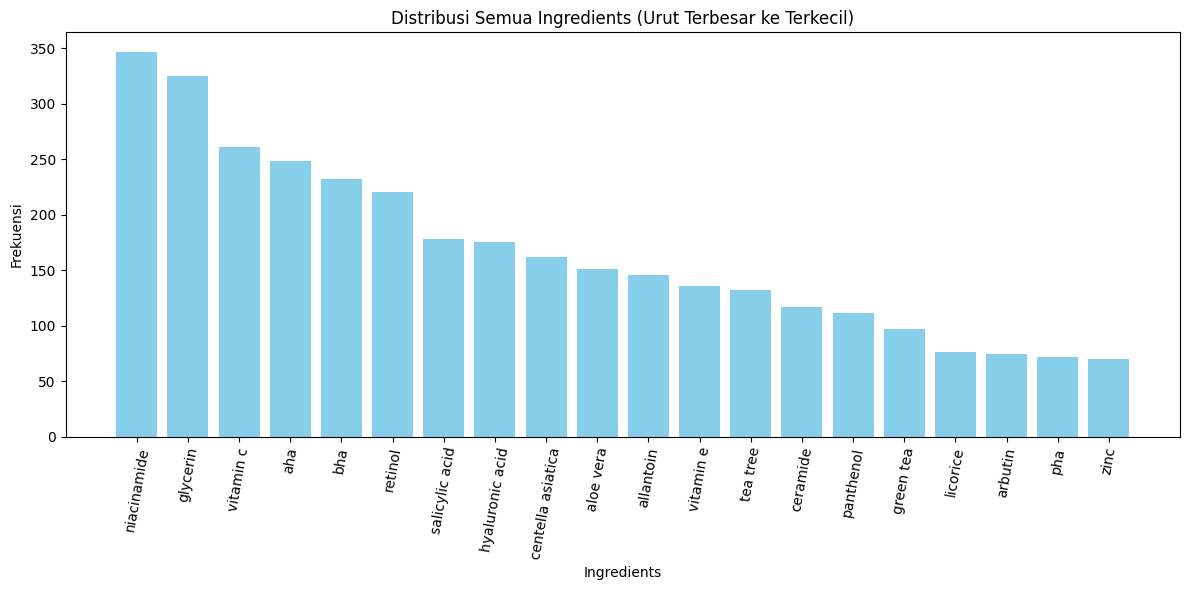

In [124]:
# Data untuk plot distribusi ingredients
# Urutkan ingredient dari frekuensi tertinggi ke terendah
sorted_ingredients = sorted(ingredient_counts.items(), key=lambda x: x[1], reverse=True)

# Pisahkan label dan nilai
labels, values = zip(*sorted_ingredients)

# Ukur ukuran plot berdasarkan jumlah labels
plt.figure(figsize=(max(12, len(labels) * 0.3), 6))

# Plot bar chart
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=80, ha='center')
plt.title('Distribusi Semua Ingredients (Urut Terbesar ke Terkecil)')
plt.xlabel('Ingredients')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

In [125]:
# Flatten semua skin_type, skin_concern, dan skin_goal menjadi satu list
all_skin_types = [item for sublist in df_cleaned['skin_type'] for item in sublist]
all_skin_concerns = [item for sublist in df_cleaned['skin_concern'] for item in sublist]
all_skin_goals = [item for sublist in df_cleaned['skin_goal'] for item in sublist]

# Hitung frekuensi kemunculan setiap skin type, concern, dan goal
skin_type_counts = Counter(all_skin_types)
skin_concern_counts = Counter(all_skin_concerns)
skin_goal_counts = Counter(all_skin_goals)

# Tampilkan berapa banyak tiap skin type, concern, dan goal yang unik
print(f"Jumlah unik skin types: {len(skin_type_counts)}")
print(f"Jumlah unik skin concerns: {len(skin_concern_counts)}")
print(f"Jumlah unik skin goals: {len(skin_goal_counts)}")

# Tampilkan jumlah kemunculan tiap skin type, concern, dan goal
print("\nJumlah kemunculan tiap skin type:")
for skin_type, count in skin_type_counts.items():
    print(f"{skin_type}: {count} kali")
print("\nJumlah kemunculan tiap skin concern:")
for skin_concern, count in skin_concern_counts.items():
    print(f"{skin_concern}: {count} kali")
print("\nJumlah kemunculan tiap skin goal:")
for skin_goal, count in skin_goal_counts.items():
    print(f"{skin_goal}: {count} kali")

Jumlah unik skin types: 5
Jumlah unik skin concerns: 15
Jumlah unik skin goals: 21

Jumlah kemunculan tiap skin type:
combination: 893 kali
oily: 637 kali
dry: 168 kali
normal: 118 kali
sensitive: 1 kali

Jumlah kemunculan tiap skin concern:
acne: 597 kali
irritation: 139 kali
dryness: 219 kali
blackheads: 84 kali
sensitive: 379 kali
redness: 73 kali
pores: 100 kali
fine lines: 34 kali
wrinkles: 22 kali
oiliness: 64 kali
tiny bumps: 19 kali
hyperpigmentation: 8 kali
whiteheads: 3 kali
dull skin: 42 kali
dark spots: 22 kali

Jumlah kemunculan tiap skin goal:
calming: 298 kali
non-comedogenic: 6 kali
brightening: 391 kali
hydrating: 538 kali
smoothing: 51 kali
fast-absorbing: 110 kali
pore-minimizing: 14 kali
barrier-repair: 25 kali
tone-evening: 24 kali
glowing: 63 kali
oil-control: 65 kali
nourishing: 24 kali
scar-fading: 31 kali
refreshing: 23 kali
regenerating: 20 kali
plumping: 30 kali
healthy: 15 kali
lightweight: 11 kali
anti-aging: 30 kali
firming: 7 kali
regenarating: 1 kali


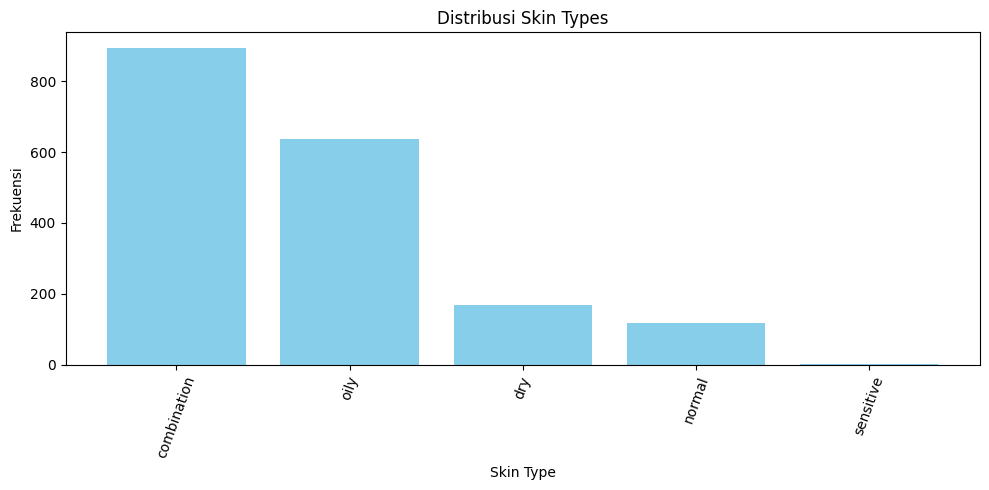

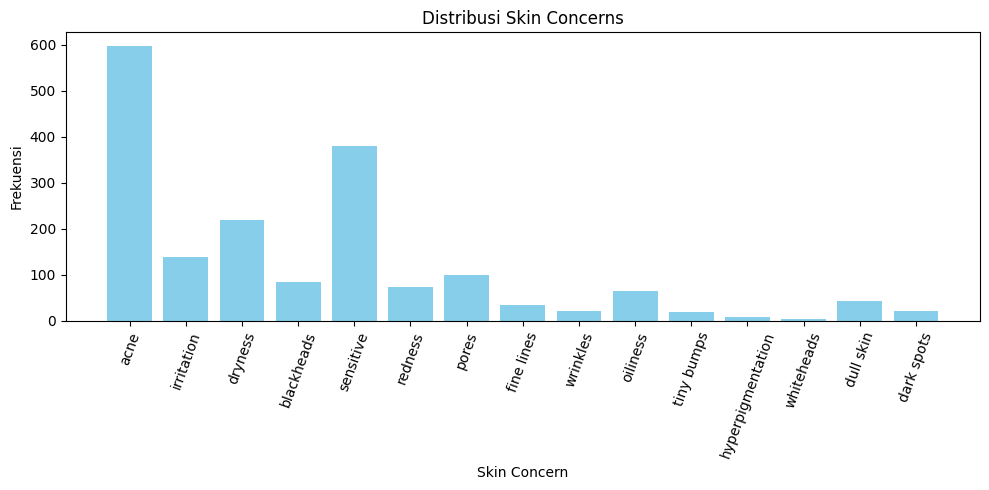

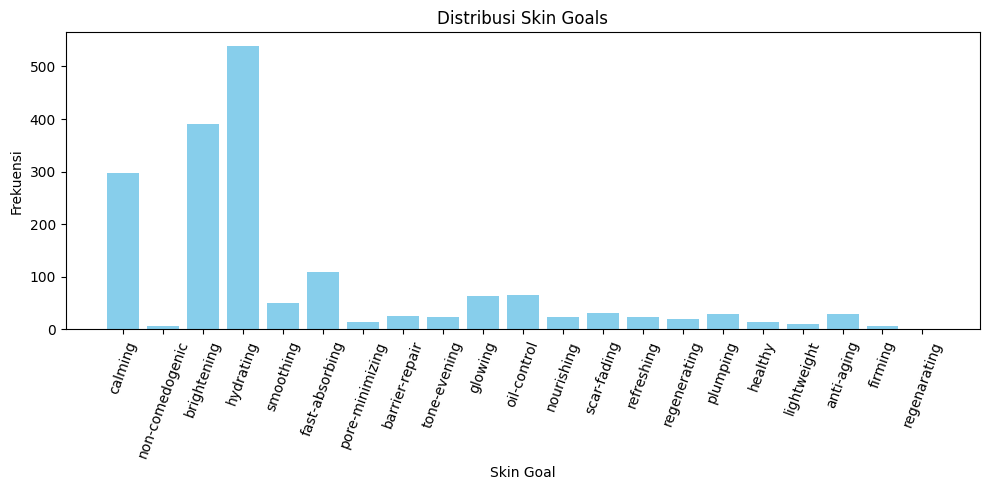

In [126]:
# Visualisasi distribusi skin types, concerns, dan goals
def plot_distribution(data, title, xlabel, ylabel):
    counts = Counter(data)
    labels, values = zip(*counts.items())
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()
    
plot_distribution(all_skin_types, 'Distribusi Skin Types', 'Skin Type', 'Frekuensi')
plot_distribution(all_skin_concerns, 'Distribusi Skin Concerns', 'Skin Concern', 'Frekuensi')
plot_distribution(all_skin_goals, 'Distribusi Skin Goals', 'Skin Goal', 'Frekuensi')

# Kode versi mein

## Preprocesing Data & Encoding

In [127]:
# Inisialisasi MultiLabelBinarizer untuk tiap fitur dan label
mlb_skin_type = MultiLabelBinarizer()
mlb_skin_concern = MultiLabelBinarizer()
mlb_skin_goal = MultiLabelBinarizer()
mlb_ingredients = MultiLabelBinarizer()

# Fit-transform fitur input dan label (ubah jadi multi-hot vectors)
X_skin_type = mlb_skin_type.fit_transform(df_cleaned['skin_type'])
X_skin_concern = mlb_skin_concern.fit_transform(df_cleaned['skin_concern'])
X_skin_goal = mlb_skin_goal.fit_transform(df_cleaned['skin_goal'])
y_ingredients = mlb_ingredients.fit_transform(df_cleaned['ingredients'])

# Gabungkan semua fitur input jadi satu matriks fitur
X = np.hstack([X_skin_type, X_skin_concern, X_skin_goal])

print("Shape fitur input:", X.shape)
print("Shape label (ingredients):", y_ingredients.shape)

Shape fitur input: (910, 41)
Shape label (ingredients): (910, 20)


## Data Splitting

In [128]:
# Split data jadi train/val/test (70:15:15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_ingredients, test_size=0.3, random_state=42, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (637, 41), (637, 20)
Validation set: (136, 41), (136, 20)
Test set: (137, 41), (137, 20)


## Data Augmentation

In [131]:
# Hitung jumlah sampel tiap label di y_train (multi-label)
print("Jumlah tiap label di train set:")
label_counts = y_train.sum(axis=0)
label_names = mlb_ingredients.classes_

df_label_counts = pd.DataFrame({
    'Ingredient': label_names,
    'Count_in_train': label_counts
}).sort_values(by='Count_in_train')

print(df_label_counts)

Jumlah tiap label di train set:
           Ingredient  Count_in_train
19               zinc              46
13                pha              46
10           licorice              55
3             arbutin              58
8           green tea              67
12          panthenol              71
6            ceramide              72
16           tea tree              84
1           allantoin             100
2           aloe vera             101
18          vitamin e             103
5   centella asiatica             107
9     hyaluronic acid             114
15     salicylic acid             127
14            retinol             144
4                 bha             156
0                 aha             156
17          vitamin c             190
7            glycerin             227
11        niacinamide             234


In [140]:
# Tentukan threshold & target
augment_threshold = 180
target_count = 200

# Simpan data augmentasi
X_aug_list = [X_train]
y_aug_list = [y_train]

print("Label yang akan diaugmentasi:")
for i, count in enumerate(label_counts):
    if count < augment_threshold:
        label = label_names[i]
        gap = target_count - count
        if gap <= 0:
            continue
        
        # Ambil semua data yang mengandung label ini
        idx = np.where(y_train[:, i] == 1)[0]
        repeat_times = int(np.ceil(gap / len(idx)))
        
        X_dup = np.tile(X_train[idx], (repeat_times, 1))[:gap]
        y_dup = np.tile(y_train[idx], (repeat_times, 1))[:gap]
        
        X_aug_list.append(X_dup)
        y_aug_list.append(y_dup)
        
        print(f"{label}: {count} → +{gap} sampel")

# Gabungkan semua data
X_augmented = np.concatenate(X_aug_list, axis=0)
y_augmented = np.concatenate(y_aug_list, axis=0)

print("\nSebelum augmentasi:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nSetelah augmentasi:")
print("X_augmented:", X_augmented.shape)
print("y_augmented:", y_augmented.shape)


Label yang akan diaugmentasi:
aha: 156 → +44 sampel
allantoin: 100 → +100 sampel
aloe vera: 101 → +99 sampel
arbutin: 58 → +142 sampel
bha: 156 → +44 sampel
centella asiatica: 107 → +93 sampel
ceramide: 72 → +128 sampel
green tea: 67 → +133 sampel
hyaluronic acid: 114 → +86 sampel
licorice: 55 → +145 sampel
panthenol: 71 → +129 sampel
pha: 46 → +154 sampel
retinol: 144 → +56 sampel
salicylic acid: 127 → +73 sampel
tea tree: 84 → +116 sampel
vitamin e: 103 → +97 sampel
zinc: 46 → +154 sampel

Sebelum augmentasi:
X_train: (637, 41)
y_train: (637, 20)

Setelah augmentasi:
X_augmented: (2430, 41)
y_augmented: (2430, 20)


## Modelling Pipeline

In [151]:
input_dim = X_augmented.shape[1]
output_dim = y_augmented.shape[1]

# Hitung class weights (inverse frequency) dari data training augmented
freq = np.sum(y_augmented, axis=0)
total = y_augmented.shape[0]
class_weights_np = total / (freq + 1e-6)
# Normalisasi supaya tidak terlalu ekstrim
class_weights_np = class_weights_np / np.max(class_weights_np)
class_weights_tf = tf.constant(class_weights_np, dtype=tf.float32)

print("Class weights:", class_weights_np)

# Definisikan weighted binary crossentropy untuk multi-label
def weighted_binary_crossentropy(y_true, y_pred):
    bce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * class_weights_tf + (1 - y_true) * 1.0
    weighted_bce = bce * weight_vector
    return K.mean(weighted_bce)

# Fungsi buat model dengan parameter (layer size, dropout)
def build_model(input_dim, output_dim, lr=0.001, dropout_rate=0.3):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(output_dim, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        loss=weighted_binary_crossentropy,
        optimizer=optimizer,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Hyperparameter tuning sederhana manual loop contoh:
best_f1 = 0
best_params = {}
for lr in [0.001, 0.0005]:
    for batch_size in [32, 64]:
        print(f"\nTraining model with lr={lr}, batch_size={batch_size}")
        model = build_model(input_dim, output_dim, lr=lr, dropout_rate=0.3)
        history = model.fit(
            X_augmented, y_augmented,
            epochs=50,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )
        # Prediksi val data untuk tuning threshold (ambil val data dari history validation split)
        # Untuk simpel, pakai X_test dan y_test sebagai evaluasi final
        y_pred_probs = model.predict(X_test)
        
        # Threshold tuning per class berdasarkan F1-score
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_thresholds = []
        for i in range(output_dim):
            f1_scores = []
            for t in thresholds:
                preds = (y_pred_probs[:, i] > t).astype(int)
                f1 = f1_score(y_test[:, i], preds)
                f1_scores.append(f1)
            best_t = thresholds[np.argmax(f1_scores)]
            best_thresholds.append(best_t)
        print("Best thresholds per class:", best_thresholds)
        
        # Prediksi akhir dengan threshold terpilih
        y_pred = np.zeros_like(y_pred_probs, dtype=int)
        for i in range(output_dim):
            y_pred[:, i] = (y_pred_probs[:, i] > best_thresholds[i]).astype(int)
        
        f1_macro = f1_score(y_test, y_pred, average='macro')
        print(f"F1 macro score on test: {f1_macro:.4f}")
        
        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_params = {'lr': lr, 'batch_size': batch_size, 'thresholds': best_thresholds}
            best_model = model
            best_y_pred = y_pred

print("\n=== Best Hyperparameters ===")
print(best_params)

# Evaluasi akhir dengan best model dan best threshold
print("\n📋 Classification Report:")
print(classification_report(y_test, best_y_pred, target_names=mlb_ingredients.classes_))

print("🎯 Accuracy Score (subset accuracy):", accuracy_score(y_test, best_y_pred))
print("🤝 F1 Score (macro):", f1_score(y_test, best_y_pred, average='macro'))
print("🤝 F1 Score (micro):", f1_score(y_test, best_y_pred, average='micro'))
print("🤝 F1 Score (weighted):", f1_score(y_test, best_y_pred, average='weighted'))
print("⚖️ Hamming Loss:", hamming_loss(y_test, best_y_pred))
print("📏 Jaccard Score (samples):", jaccard_score(y_test, best_y_pred, average='samples'))


# Plot training metrics fungsi (optional)
import matplotlib.pyplot as plt
def plot_metrics(history):
    metrics = ['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy', 'auc', 'val_auc', 'precision', 'val_precision', 'recall', 'val_recall']
    for metric in metrics:
        if metric in history.history:
            plt.figure(figsize=(6,4))
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history['val_' + metric.split("_")[-1]], label=f'Val {metric.split("_")[-1]}')
            plt.title(metric)
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

Class weights: [0.39636364 0.53960396 0.71710526 0.87433155 0.37414188 0.5109375
 0.76401869 0.33504098 0.97321429 0.57267951 0.89835165 0.29727273
 0.65662651 0.86507937 0.42689295 0.5093458  0.77672209 0.4002448
 0.75519631 1.        ]

Training model with lr=0.001, batch_size=32
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - auc: 0.5171 - binary_accuracy: 0.5195 - loss: 0.7661 - precision: 0.2533 - recall: 0.5013 - val_auc: 0.5681 - val_binary_accuracy: 0.6663 - val_loss: 0.5781 - val_precision: 0.2552 - val_recall: 0.2347
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.5933 - binary_accuracy: 0.5906 - loss: 0.6193 - precision: 0.3051 - recall: 0.5202 - val_auc: 0.6044 - val_binary_accuracy: 0.7443 - val_loss: 0.5088 - val_precision: 0.2809 - val_recall: 0.0711
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.6404 - binary_accuracy: 0.6652 - loss: 0.5245 - precision: 0.3673 - recall: 0.4667 - val_auc: 0.6275 - val_binary_accuracy: 0.7670 - val_loss: 0.43

/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [144]:
# Build Model
input_dim = X_augmented.shape[1]
output_dim = y_augmented.shape[1]

model = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(output_dim, activation='sigmoid')  # multi-label output
])

In [145]:
# Compile and Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [146]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - auc: 0.5235 - binary_accuracy: 0.5065 - loss: 0.6958 - precision: 0.1776 - recall: 0.5237 - val_auc: 0.5826 - val_binary_accuracy: 0.7383 - val_loss: 0.6169 - val_precision: 0.2730 - val_recall: 0.2093
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.5438 - binary_accuracy: 0.7312 - loss: 0.5943 - precision: 0.2051 - recall: 0.2070 - val_auc: 0.6192 - val_binary_accuracy: 0.7957 - val_loss: 0.5146 - val_precision: 0.1905 - val_recall: 0.0161
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.5865 - binary_accuracy: 0.8054 - loss: 0.4969 - precision: 0.2556 - recall: 0.0715 - val_auc: 0.6573 - val_binary_accuracy: 0.8059 - val_loss: 0.4688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - auc: 0.6294 - binary_accuracy: 0.8249 - loss: 0.4511 - precision: 0.3259 - recall: 0.0408 - val_auc: 0.6750 - val_binary_accuracy: 0.8062 - val_loss: 0.4644 - val_precision: 

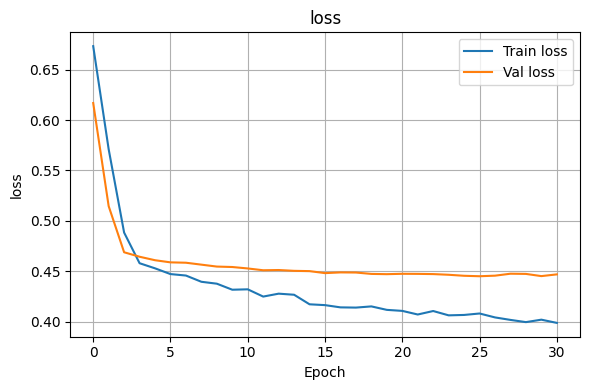

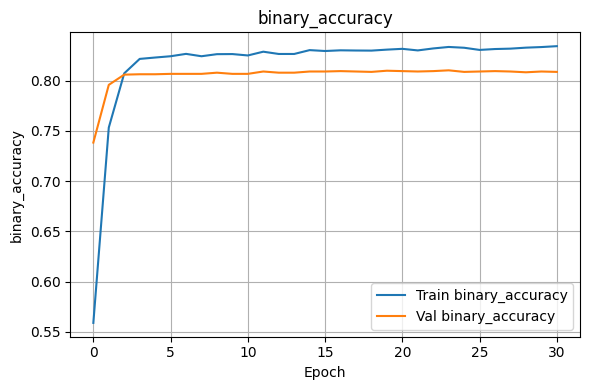

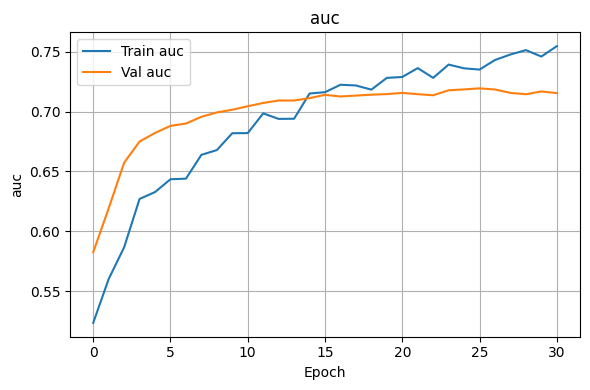

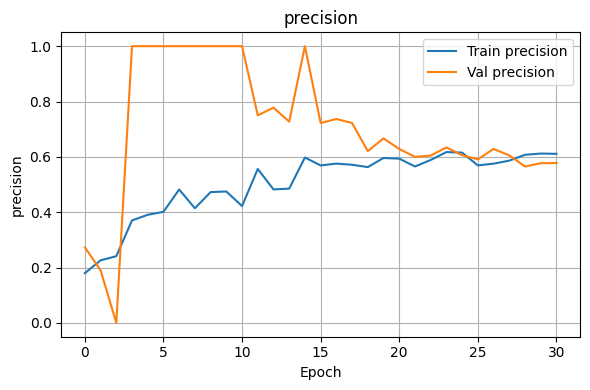

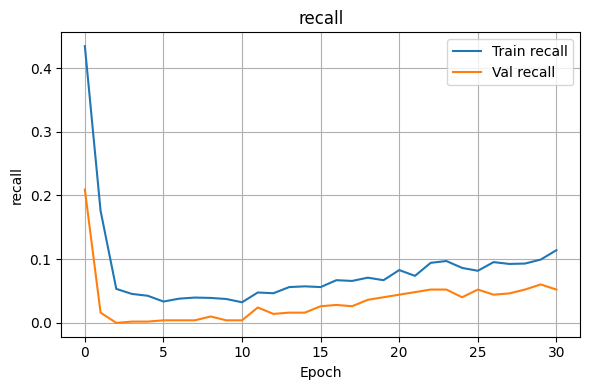

In [147]:
# Visualisasi Training
def plot_metrics(history):
    metrics = ['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy']
    for metric in ['loss', 'binary_accuracy', 'auc', 'precision', 'recall']:
        plt.figure(figsize=(6,4))
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history['val_' + metric], label=f'Val {metric}')
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_metrics(history)

In [148]:
# Predict
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Multi-label evaluation
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb_ingredients.classes_))

# Other multi-label metrics
print("🎯 Accuracy Score (subset accuracy):", accuracy_score(y_test, y_pred))
print("🤝 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("🤝 F1 Score (micro):", f1_score(y_test, y_pred, average='micro'))
print("🤝 F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("⚖️ Hamming Loss:", hamming_loss(y_test, y_pred))
print("📏 Jaccard Score (samples):", jaccard_score(y_test, y_pred, average='samples'))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

📋 Classification Report:
                   precision    recall  f1-score   support

              aha       0.00      0.00      0.00        43
        allantoin       0.00      0.00      0.00        20
        aloe vera       0.00      0.00      0.00        28
          arbutin       0.00      0.00      0.00         7
              bha       0.00      0.00      0.00        35
centella asiatica       0.00      0.00      0.00        26
         ceramide       0.00      0.00      0.00        27
         glycerin       0.50      0.06      0.10        52
        green tea       0.00      0.00      0.00        16
  hyaluronic acid       0.00      0.00      0.00        34
         licorice       0.00      0.00      0.00        13
      niacinamide       0.62      0.21      0.32        61
        panthenol       0.00      0.00      0.00        18
              pha       0.00      0.00      0.00        11
          retinol       0.00      0.00      0.00  

/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jasmein/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Augmentasi Data

In [108]:
# Validasi input untuk skin_type, skin_concern, dan skin_goal
valid_skin_types = ['dry', 'oily', 'normal', 'combination', 'sensitive']
valid_skin_concerns = ['acne', 'dark spots', 'hyperpigmentation', 'wrinkles', 'redness',
                       'oiliness', 'dryness', 'pores', 'uneven texture', 'fine lines',
                       'blackheads', 'whiteheads', 'sensitive', 'dull skin', 'tiny bumps',
                        'irritation', 'fine lines']
valid_skin_goals = ['brightening', 'glowing','plumping', 'hydrating', 'firming',
                    'smoothing','tone-evening', 'anti-aging', 'barrier-repair',
                    'oil-control', 'pore-minimizing', 'scar-fading', 'refreshing',
                    'regenerating', 'healthy', 'nourishing', 'calming', 'lightweight',
                    'non-comedogenic', 'fast-absorbing']

In [109]:
# Proses augmentasi data
# 1. Hitung label awal
all_ingredients_flat = [label for labels in df_cleaned['ingredients'] for label in labels]
label_counts = Counter(all_ingredients_flat)

# 2. Tetapkan threshold minoritas dan target maksimal setelah augmentasi
MINORITY_THRESHOLD = 300
TARGET_LABEL_COUNT = 300

minority_labels = set([label for label, count in label_counts.items() if count < MINORITY_THRESHOLD])

# 3. Valid skin_concern dan skin_goal
# valid_skin_concerns = sorted(set([c for sublist in df_cleaned['skin_concern'] for c in sublist]))
# valid_skin_goals = sorted(set([g for sublist in df_cleaned['skin_goal'] for g in sublist]))

# 4. Salin label_counts agar kita bisa update saat augmentasi
augmented_label_counts = dict(label_counts)
augmented_data = []

# 5. Fungsi augmentasi satu baris
def generate_augmented_row(row):
    new_row = row.copy()

    # Acak skin_concern dan skin_goal
    new_row['skin_concern'] = random.sample(new_row['skin_concern'], len(new_row['skin_concern']))
    new_row['skin_goal'] = random.sample(new_row['skin_goal'], len(new_row['skin_goal']))

    # Tambah concern atau goal jika < 3
    if random.random() < 0.5 and len(new_row['skin_concern']) < 3:
        additional = random.choice([c for c in valid_skin_concerns if c not in new_row['skin_concern']])
        new_row['skin_concern'].append(additional)
    elif len(new_row['skin_goal']) < 3:
        additional = random.choice([g for g in valid_skin_goals if g not in new_row['skin_goal']])
        new_row['skin_goal'].append(additional)

    # Simpan hanya label minoritas
    new_ingredients = [label for label in row['ingredients'] if label in minority_labels]

    # Jika tidak ada label minoritas, lewati
    if not new_ingredients:
        return None

    # Cek apakah semua label minoritas ini masih di bawah target
    if all(augmented_label_counts[label] < TARGET_LABEL_COUNT for label in new_ingredients):
        new_row['ingredients'] = new_ingredients
        # Update jumlah label
        for label in new_ingredients:
            augmented_label_counts[label] += 1
        return new_row
    else:
        return None

# 6. Iterasi semua baris dan augment jika memungkinkan
for _, row in df_cleaned.iterrows():
    for _ in range(3):  # Bisa 1–3 augmentasi per baris
        augmented_row = generate_augmented_row(row)
        if augmented_row is not None:
            augmented_data.append(augmented_row)

# 7. Gabungkan
df_augmented = pd.DataFrame(augmented_data)
df_full = pd.concat([df_cleaned, df_augmented], ignore_index=True)

In [110]:
# Cek hasil augmentasi
print(f"Jumlah baris sebelum augmentasi: {len(df_cleaned)}")
print(f"Jumlah baris setelah augmentasi: {len(df_full)}")
print("Jumlah label unik setelah augmentasi:")
print(len(set([label for sublist in df_full['ingredients'] for label in sublist])))
print("Jumlah label per kolom:")
for col in df_full.columns:
    print(f"{col}: {df_full[col].apply(lambda x: len(x)).sum()}")
    
# Tampilkan informasi DataFrame lengkap
df_full.info()

Jumlah baris sebelum augmentasi: 910
Jumlah baris setelah augmentasi: 1844
Jumlah label unik setelah augmentasi:
20
Jumlah label per kolom:
skin_type: 3679
skin_concern: 4111
skin_goal: 4042
ingredients: 5177
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   skin_type     1844 non-null   object
 1   skin_concern  1844 non-null   object
 2   skin_goal     1844 non-null   object
 3   ingredients   1844 non-null   object
dtypes: object(4)
memory usage: 57.8+ KB


niacinamide: 347 kali
glycerin: 325 kali
salicylic acid: 300 kali
bha: 300 kali
retinol: 300 kali
centella asiatica: 300 kali
aha: 300 kali
vitamin c: 300 kali
aloe vera: 300 kali
hyaluronic acid: 300 kali
vitamin e: 300 kali
allantoin: 290 kali
tea tree: 280 kali
green tea: 235 kali
ceramide: 233 kali
panthenol: 207 kali
licorice: 172 kali
zinc: 155 kali
arbutin: 143 kali
pha: 90 kali


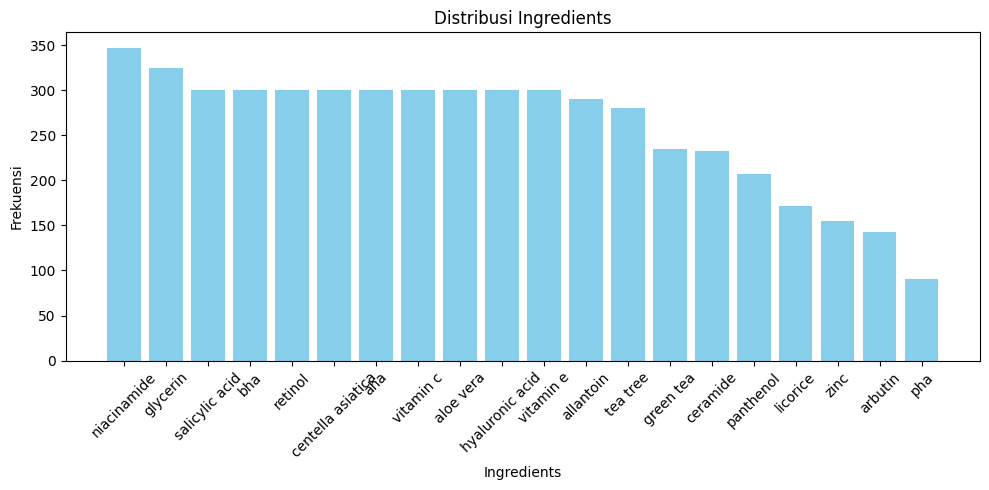

In [111]:
# Flatten semua ingredients menjadi satu list
all_ingredients = [item for sublist in df_full['ingredients'] for item in sublist]

# Hitung frekuensi kemunculan setiap ingredient
ingredient_counts = Counter(all_ingredients)

# Ambil ingredients yang sering muncul
common_ingredients = ingredient_counts.most_common(50)

for ingredient, count in common_ingredients:
    print(f"{ingredient}: {count} kali")

# Data untuk plot
labels, values = zip(*common_ingredients)

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.title('Distribusi Ingredients')
plt.xlabel('Ingredients')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Hitung label awal
all_ingredients_flat = [label for labels in df_full['ingredients'] for label in labels]
label_counts = Counter(all_ingredients_flat)

# 2. Tetapkan threshold minoritas dan target maksimal setelah augmentasi
MINORITY_THRESHOLD = 275
TARGET_LABEL_COUNT = 250

minority_labels = set([label for label, count in label_counts.items() if count < MINORITY_THRESHOLD])

# 3. Valid skin_concern dan skin_goal
# valid_skin_concerns = sorted(set([c for sublist in df_full['skin_concern'] for c in sublist]))
# valid_skin_goals = sorted(set([g for sublist in df_full['skin_goal'] for g in sublist]))

# 4. Salin label_counts agar kita bisa update saat augmentasi
augmented_label_counts = dict(label_counts)
augmented_data = []

# 5. Fungsi augmentasi satu baris
def generate_augmented_row(row):
    new_row = row.copy()

    # Acak skin_concern dan skin_goal
    new_row['skin_concern'] = random.sample(new_row['skin_concern'], len(new_row['skin_concern']))
    new_row['skin_goal'] = random.sample(new_row['skin_goal'], len(new_row['skin_goal']))

    # Tambah concern atau goal jika < 3
    if random.random() < 0.5 and len(new_row['skin_concern']) < 3:
        additional = random.choice([c for c in valid_skin_concerns if c not in new_row['skin_concern']])
        new_row['skin_concern'].append(additional)
    elif len(new_row['skin_goal']) < 3:
        additional = random.choice([g for g in valid_skin_goals if g not in new_row['skin_goal']])
        new_row['skin_goal'].append(additional)

    # Simpan hanya label minoritas
    new_ingredients = [label for label in row['ingredients'] if label in minority_labels]

    # Jika tidak ada label minoritas, lewati
    if not new_ingredients:
        return None

    # Cek apakah semua label minoritas ini masih di bawah target
    if all(augmented_label_counts[label] < TARGET_LABEL_COUNT for label in new_ingredients):
        new_row['ingredients'] = new_ingredients
        # Update jumlah label
        for label in new_ingredients:
            augmented_label_counts[label] += 1
        return new_row
    else:
        return None

# 6. Iterasi semua baris dan augment jika memungkinkan
for _, row in df_full.iterrows():
    for _ in range(3):  # Bisa 1–3 augmentasi per baris
        augmented_row = generate_augmented_row(row)
        if augmented_row is not None:
            augmented_data.append(augmented_row)

# 7. Gabungkan
df_augmented = pd.DataFrame(augmented_data)
df_full_2 = pd.concat([df_full, df_augmented], ignore_index=True)

niacinamide: 347 kali
glycerin: 325 kali
salicylic acid: 300 kali
bha: 300 kali
retinol: 300 kali
centella asiatica: 300 kali
aha: 300 kali
vitamin c: 300 kali
aloe vera: 300 kali
hyaluronic acid: 300 kali
vitamin e: 300 kali
allantoin: 290 kali
tea tree: 280 kali
panthenol: 250 kali
ceramide: 250 kali
green tea: 250 kali
licorice: 250 kali
zinc: 250 kali
arbutin: 250 kali
pha: 239 kali


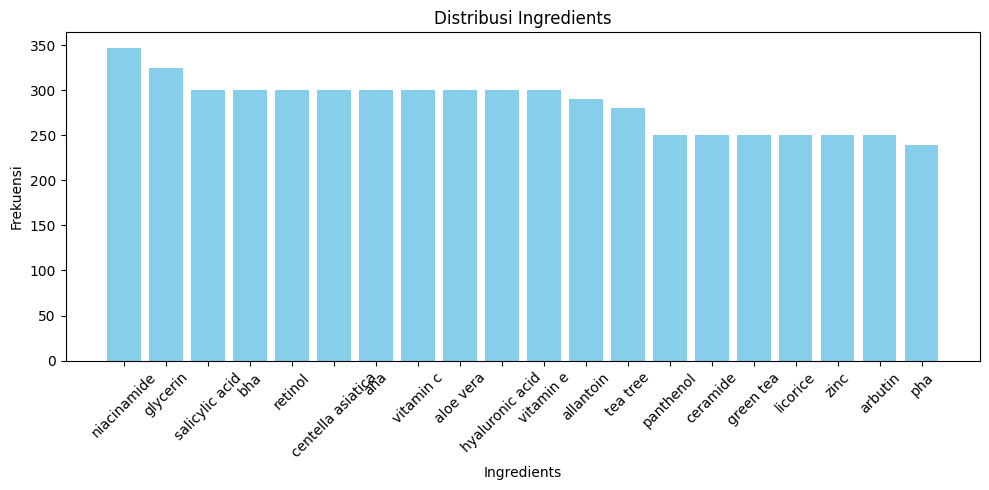

In [ ]:
# Flatten semua ingredients menjadi satu list
all_ingredients = [item for sublist in df_full_2['ingredients'] for item in sublist]

# Hitung frekuensi kemunculan setiap ingredient
ingredient_counts = Counter(all_ingredients)

# Ambil ingredients yang sering muncul
common_ingredients = ingredient_counts.most_common(50)

for ingredient, count in common_ingredients:
    print(f"{ingredient}: {count} kali")

# Data untuk plot
labels, values = zip(*common_ingredients)

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.title('Distribusi Ingredients')
plt.xlabel('Ingredients')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_full_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   skin_type     2278 non-null   object
 1   skin_concern  2278 non-null   object
 2   skin_goal     2278 non-null   object
 3   ingredients   2278 non-null   object
dtypes: object(4)
memory usage: 71.3+ KB


In [ ]:
df_model = df_full_2.copy()

# Modeling

In [ ]:
# Fungsi focal loss untuk multi-label classification
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        """
        Focal loss for multi-label classification.
        y_true: ground truth labels, shape of [batch_size, num_classes]
        y_pred: predicted probabilities, shape of [batch_size, num_classes]
        """
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + \
                 (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy

        return K.mean(K.sum(loss, axis=1))  # sum over classes, mean over batch
    return focal_loss_fixed

## Data preparation

In [ ]:
# 1. Encode label multi-label jadi multi-hot
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_model['ingredients'])
all_ingredients = mlb.classes_

In [ ]:
# Daftar data ingredients
print(all_ingredients)
print(len(all_ingredients))

['aha' 'allantoin' 'aloe vera' 'arbutin' 'bha' 'centella asiatica'
 'ceramide' 'glycerin' 'green tea' 'hyaluronic acid' 'licorice'
 'niacinamide' 'panthenol' 'pha' 'retinol' 'salicylic acid' 'tea tree'
 'vitamin c' 'vitamin e' 'zinc']
20


In [ ]:
# Gabungkan tiga fitur menjadi satu string
df_model['text_input'] = df_model.apply(lambda row: ' '.join(row['skin_type'] + row['skin_concern'] + row['skin_goal']), axis=1)

### Split Data

In [ ]:
# 2. Split dataset (75% train, 15% val, 10% test)
X_temp, X_test, y_temp, y_test = train_test_split(df_model['text_input'], y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1667, random_state=42)

X_train = X_train.astype(str).to_numpy()
X_val = X_val.astype(str).to_numpy()
X_test = X_test.astype(str).to_numpy()

# Cek
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1708,)
(342,)
(228,)


In [ ]:
# 3. Text vectorization setup
vectorizer = TextVectorization(
    max_tokens=200,
    output_mode='multi_hot'
)
vectorizer.adapt(X_train)

## Build Model

In [ ]:
# Model
model = tf.keras.Sequential([
    vectorizer,
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(all_ingredients), activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss=focal_loss(alpha=0.25, gamma=2),  # tetap pakai focal loss
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
# 7. Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32
)

Epoch 1/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.5129 - loss: 1.8051 - precision: 0.1332 - recall: 0.2548 - val_auc: 0.5578 - val_loss: 0.6943 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.5271 - loss: 0.8444 - precision: 0.1159 - recall: 0.0021 - val_auc: 0.6099 - val_loss: 0.6725 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.5609 - loss: 0.7905 - precision: 0.1587 - recall: 9.1801e-04 - val_auc: 0.6562 - val_loss: 0.6596 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.5931 - loss: 0.7576 - precision: 0.1804 - recall: 4.2272e-04 - val_auc: 0.6720 - val_loss: 0.6533 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/500
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6063 - loss: 0.7452 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.6801 - val_loss: 0.64

## Evaluasi

In [ ]:
# 1. Prediksi probabilitas
y_pred = model.predict(X_test)

# 2. Konversi ke nilai 0/1 berdasarkan threshold
TRESHOLD = 0.35
y_pred_binary = (y_pred >= TRESHOLD).astype(int)

# 3. Evaluasi model
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')
hamming = hamming_loss(y_test, y_pred_binary)

# 4. Tampilkan hasil
print("📊 Evaluasi Model Multi-Label Classification")
print("Precision        :", precision)
print("Recall           :", recall)
print("F1 Score         :", f1)
print("Hamming Loss     :", hamming)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
📊 Evaluasi Model Multi-Label Classification
Precision        : 0.46511627906976744
Recall           : 0.3424657534246575
F1 Score         : 0.39447731755424065
Hamming Loss     : 0.13464912280701755


In [ ]:
# Uji prediksi satu sample acak
# Ambil index acak dari data uji
# index = random.randint(0, len(X_test) - 1)
index = 16
# Prediksi biner untuk sample tersebut
sample_pred = np.array([y_pred_binary[index]])
sample_true = np.array([y_test[index]])

# Konversi ke bentuk label ingredients
predicted_ingredients = mlb.inverse_transform(sample_pred)[0]
actual_ingredients = mlb.inverse_transform(sample_true)[0]

# Ambil fitur input aslinya dari X_test_text (sebelum vektorisasi)
input_text = X_test[index]  # Asumsinya kamu menyimpan text asli sebelum tokenizer di X_test_text

print("\nContoh Prediksi dengan Index Acak:", index)
print("Input:")
print(input_text)
print("\nPredicted Ingredients:", predicted_ingredients)
print("Actual Ingredients   :", actual_ingredients)


Contoh Prediksi dengan Index Acak: 16
Input:
combination oily wrinkles irritation blackheads plumping hydrating

Predicted Ingredients: ('vitamin e',)
Actual Ingredients   : ('vitamin e',)


## Inference Model

In [ ]:
def predict_ingredients(skin_type_list, skin_concern_list, skin_goal_list, model, mlb, threshold):
    """
    Fungsi untuk prediksi ingredients berdasarkan input user.

    Parameters:
        skin_type_list: list of str
        skin_concern_list: list of str
        skin_goal_list: list of str
        model: model TensorFlow yang sudah dilatih
        mlb: MultiLabelBinarizer yang sudah dilatih
        threshold: float

    Returns:
        List of predicted ingredients
    """
    # Gabungkan input menjadi satu string seperti pada preprocessing
    text_input = ' '.join(skin_type_list + skin_concern_list + skin_goal_list)

    # Konversi jadi array string NumPy
    text_array = np.array([text_input], dtype=object)

    # Prediksi probabilitas
    pred_probs = model.predict(text_array)

    # Threshold → multi-label biner
    pred_binary = (pred_probs >= threshold).astype(int)

    # Decode kembali ke label ingredients
    predicted_labels = mlb.inverse_transform(pred_binary)[0]

    return predicted_labels

In [ ]:
# Input user (bisa dikosongkan sebagian)
skin_type_input = ['dry']
skin_concern_input = ['acne','irritation','sensitive','redness']
skin_goal_input = ['glowing','brightening']

predicted = predict_ingredients(
    skin_type_input,
    skin_concern_input,
    skin_goal_input,
    model=model,
    mlb=mlb,
    threshold=0.4
)
if not predicted:
    print("changing treshold to 0.35...")
    predicted = predict_ingredients(
        skin_type_input,
        skin_concern_input,
        skin_goal_input,
        model=model,
        mlb=mlb,
        threshold=0.35
    )
    if not predicted:
        print("changing treshold to 0.3...")
        predicted = predict_ingredients(
            skin_type_input,
            skin_concern_input,
            skin_goal_input,
            model=model,
            mlb=mlb,
            threshold=0.3
        )

print("Predicted Ingredients:", predicted)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Ingredients: ('licorice',)


## Save Model

In [ ]:
# Simpan model TensorFlow
model.save('ingredients_classification_model.keras')

# Simpan MultiLabelBinarizer pakai pickle
import pickle
with open('ingredients_mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)